### Fetch Stock Data

In [1]:
from models.black_scholes import black_scholes
from yfinance import Ticker
from numpy import log, sqrt

# Define the stock symbol
symbol = "AAPL"

# Live data for symbol
stock_data = Ticker(symbol)

# Current stock price
current_price = stock_data.history(period="1d")['Close'].iloc[-1]

# Historical data if needed for volatility calculation
historical_data = stock_data.history(period="1y")['Close']

# Calculate annualized volatility
log_returns = log(historical_data / historical_data.shift(1)).dropna()
volatility = log_returns.std() * sqrt(252)  # Annualized volatility

# Print the fetched data
print(f"Current Price: {current_price}")
print(f"Volatility (Annualized): {volatility:.2f}")

Current Price: 229.0
Volatility (Annualized): 0.22


### Define Model Parameters

In [2]:
from clients.tradingview import get_risk_free_rate

# Example parameters
S = current_price       # Current stock price from live data
K = 150                 # Strike price
T = 30 / 365            # Time to maturity in years (e.g., 30 days)
r = get_risk_free_rate(T) # Risk-free rate from TradingView API
sigma = volatility      # Volatility from live data
option_type = 'call'    # Option type (call/put)

# Calculate option price
option_price = black_scholes(S, K, T, r, sigma, option_type)

print(f"{option_type.title()} Option Price: {option_price:.2f}")

you are using nologin method, data you access may be limited


Selected ticker: US01MY for maturity 0.08 years
Risk-Free Rate: 5.2710%
Call Option Price: 79.65


### Plot the Option Prices Against the Stock Price

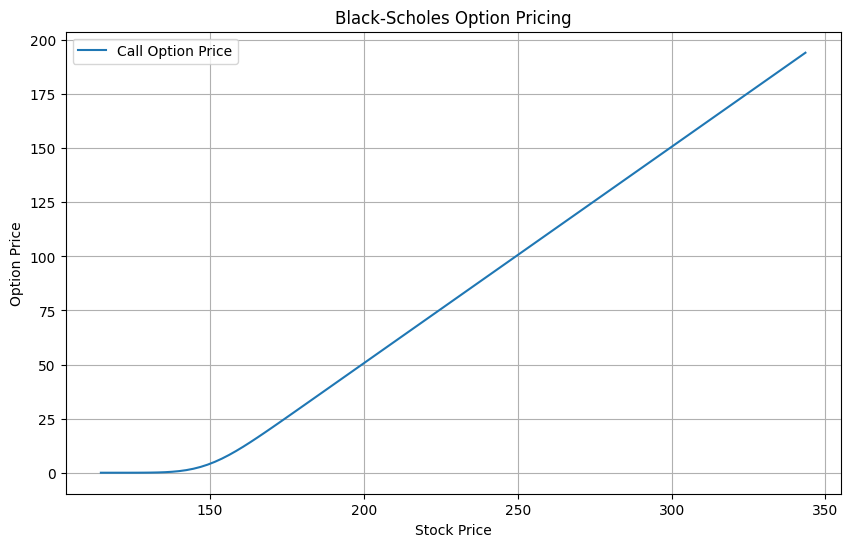

In [3]:
from numpy import linspace
import matplotlib.pyplot as plt

# range ±50% of the current price
S_min = current_price * 0.5
S_max = current_price * 1.5
S_values = linspace(S_min, S_max, 100)

# Calculate option prices for each stock price
option_prices = [black_scholes(S, K, T, r, sigma, option_type) for S in S_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(S_values, option_prices, label=f'{option_type.title()} Option Price')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('Black-Scholes Option Pricing')
plt.legend()
plt.grid(True)
plt.show()

### Automated Pricing + Greeks Analysis

In [5]:
import time
from models.options import black_scholes_greeks

while True:
    current_price = stock_data.history(period="1d")['Close'].iloc[-1]
    
    # Update and recalculate other variables
    option_price = black_scholes(S, K, T, r, sigma, option_type)
    greeks = black_scholes_greeks(S, K, T, r, sigma, option_type)
    
    print(f"Current Price: {S:.2f}")
    print(f"{option_type.title()} Price: {option_price:.2f}, Delta: {greeks.Delta:.2f}, Gamma: {greeks.Gamma:.2f}, Vega: {greeks.Vega:.2f}, Theta: {greeks.Theta:.2f}, Rho: {greeks.Rho:.2f}")

    if greeks.Theta < -0.1:
        print("Warning: Theta is high, consider shorter maturities.")
        # indicates a significant time decay. Options with high negative Theta lose value quickly as expiration approaches.
        
    if greeks.Delta > 0.5:
        print("Warning: Delta is high, consider hedging.")
    if greeks.Gamma > 0.1:
        print("Alert: Gamma is high, significant volatility risk.")
    if greeks.Vega > 0.2:
        print("Alert: Vega is high, volatility risk is significant.")
    if greeks.Rho > 0.1:
        print("Warning: Rho is high, consider higher interest rates.")
    
    # Wait for a specified time before fetching the data again (e.g., 60 seconds)
    time.sleep(60)

Current Price: 229.00
Call Price: 79.65, Delta: 1.00, Gamma: 0.00, Vega: 0.00, Theta: -7.87, Rho: 12.28
